In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phiusiil-phishing-url/PhiUSIIL_Phishing_URL_Dataset.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import torch
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
#import torchtext

import transformers
from transformers import DistilBertForSequenceClassification, AdamW

In [3]:
df_raw = pd.read_csv('/kaggle/input/phiusiil-phishing-url/PhiUSIIL_Phishing_URL_Dataset.csv')

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

In [5]:
columns = [ 'URL'  ,'Domain', 'TLD',  'URLSimilarityIndex' ,'NoOfOtherSpecialCharsInURL' , 
 'SpacialCharRatioInURL','IsHTTPS', 'LineOfCode' ,'Title' , 'DomainTitleMatchScore', 'URLTitleMatchScore' ,'IsResponsive'               
,'HasDescription' , 'HasSocialNet' , 'HasSubmitButton','HasCopyrightInfo' , 'NoOfImage' ,  'NoOfJS', 'NoOfSelfRef'                
   ,'label']
df = df_raw[columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   URL                         235795 non-null  object 
 1   Domain                      235795 non-null  object 
 2   TLD                         235795 non-null  object 
 3   URLSimilarityIndex          235795 non-null  float64
 4   NoOfOtherSpecialCharsInURL  235795 non-null  int64  
 5   SpacialCharRatioInURL       235795 non-null  float64
 6   IsHTTPS                     235795 non-null  int64  
 7   LineOfCode                  235795 non-null  int64  
 8   Title                       235795 non-null  object 
 9   DomainTitleMatchScore       235795 non-null  float64
 10  URLTitleMatchScore          235795 non-null  float64
 11  IsResponsive                235795 non-null  int64  
 12  HasDescription              235795 non-null  int64  
 13  HasSocialNet  

In [6]:
data = df.copy()
object_cols = [i for i in df.columns.tolist() if df[i].dtype=="object"]
data.drop(object_cols, axis=1, inplace=True)

In [7]:
top_corr = data.corrwith(data["label"]).abs().sort_values(ascending=False)[:6].index.to_list()

In [8]:
top_corr

['label',
 'URLSimilarityIndex',
 'HasSocialNet',
 'HasCopyrightInfo',
 'HasDescription',
 'IsHTTPS']

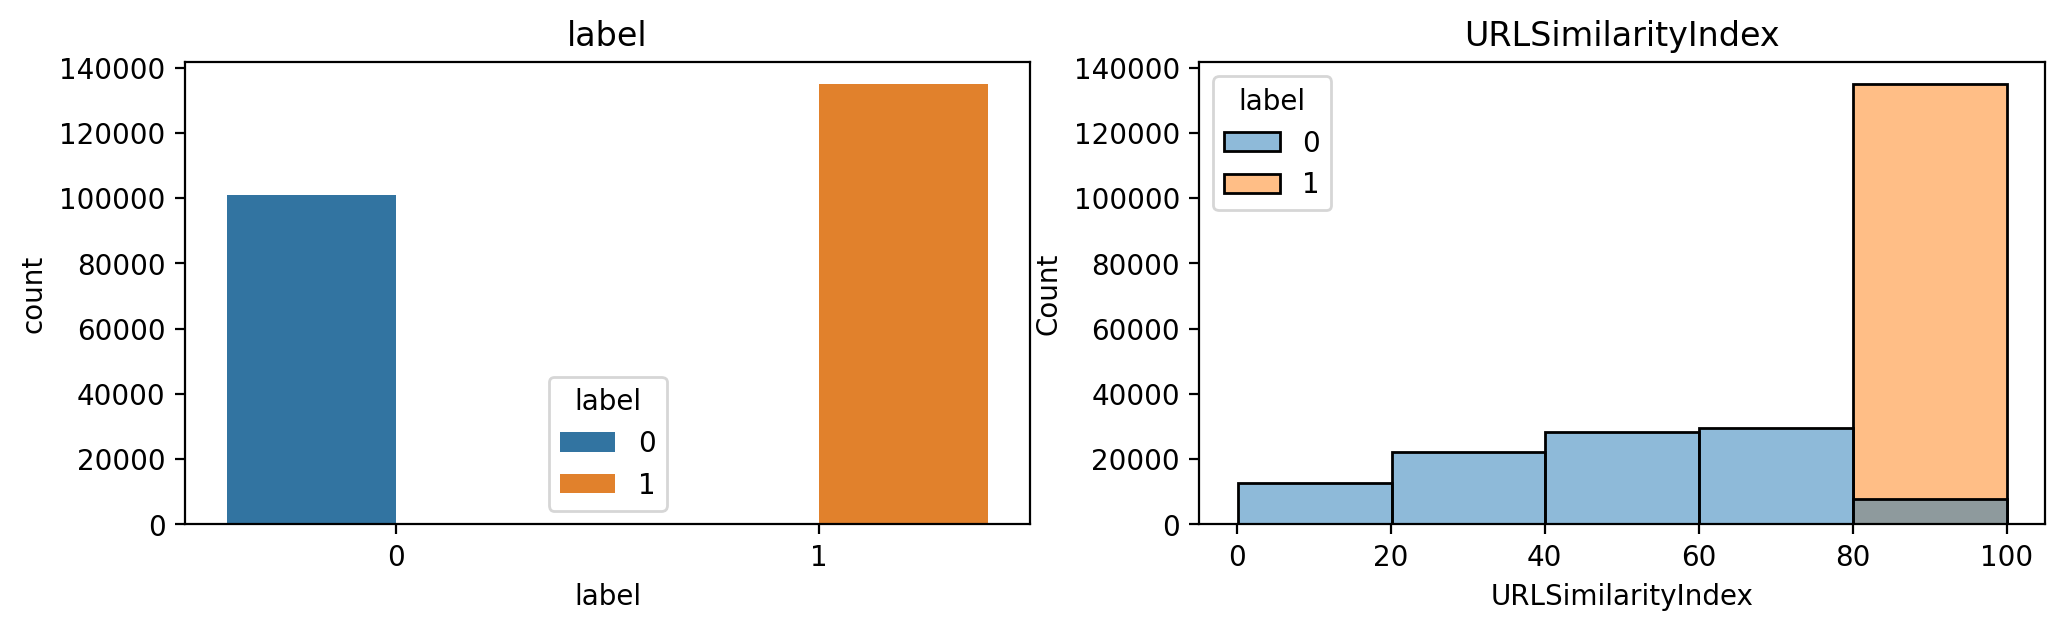

In [9]:
fig = plt.figure(figsize=(12, 3), dpi=200)
ax = fig.add_axes(121)
ax2 = fig.add_axes(122)


sns.countplot(data[top_corr], x="label", hue="label", ax=ax)
ax.set_title("label")

sns.histplot(data[top_corr],bins=5, x="URLSimilarityIndex", hue="label", ax=ax2)
ax2.set_title("URLSimilarityIndex");

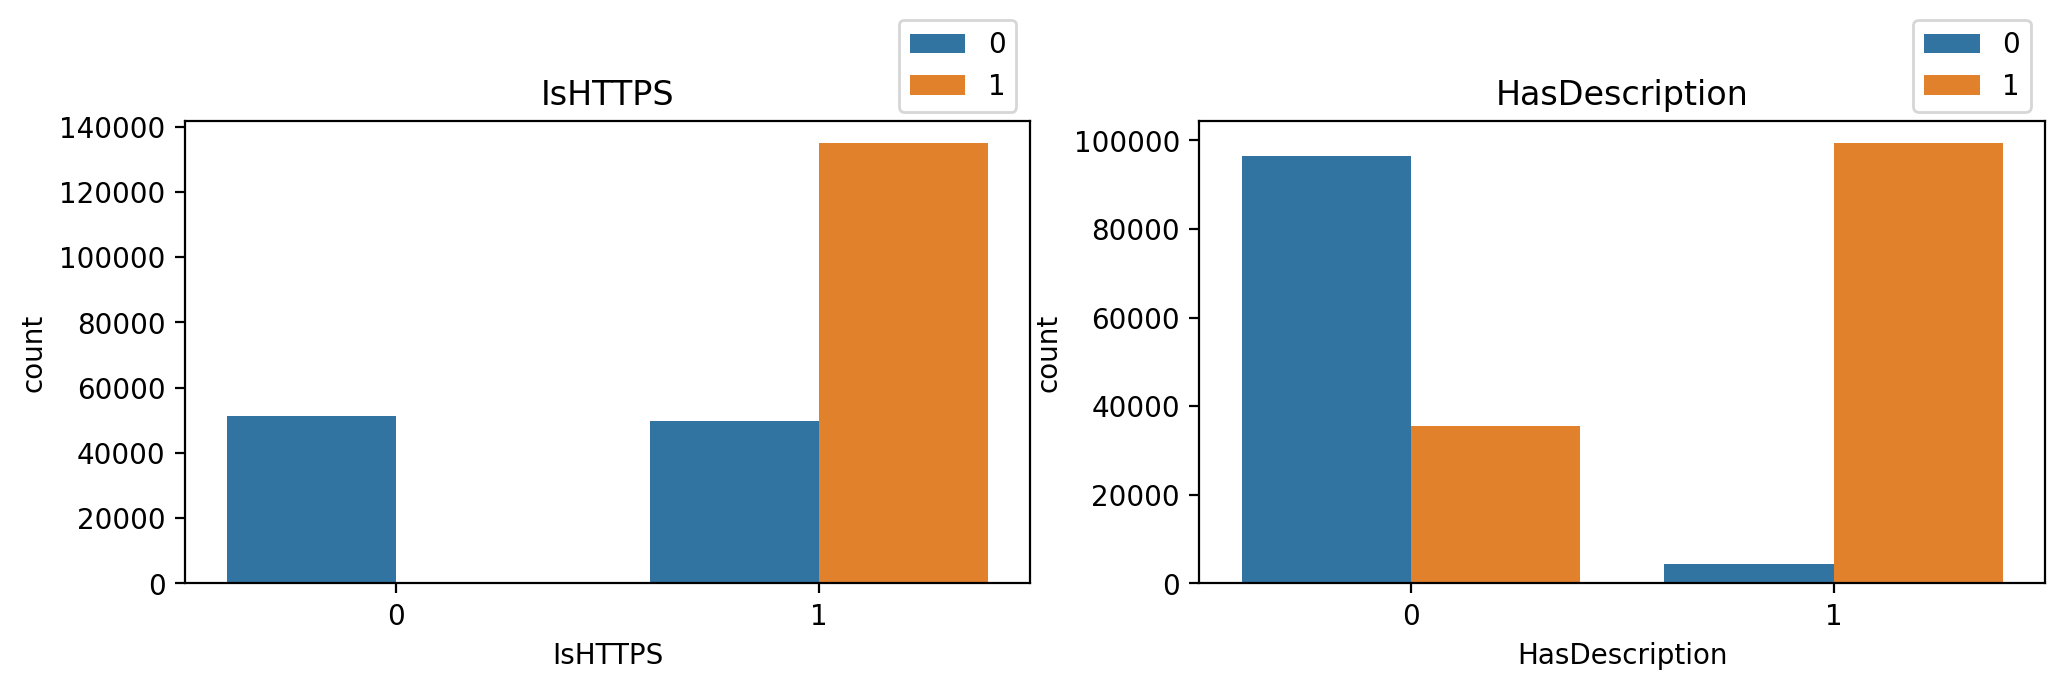

In [10]:
fig = plt.figure(figsize=(12, 3), dpi=200)
ax = fig.add_axes(121)
ax2 = fig.add_axes(122)

sns.countplot(data[top_corr], x="IsHTTPS", hue="label", ax=ax)
ax.set_title("IsHTTPS")
ax.legend(bbox_to_anchor=(1, 1.25))

sns.countplot(data[top_corr], x="HasDescription", hue="label", ax=ax2)
ax2.set_title("HasDescription")
ax2.legend(bbox_to_anchor=(1, 1.25));

<Axes: >

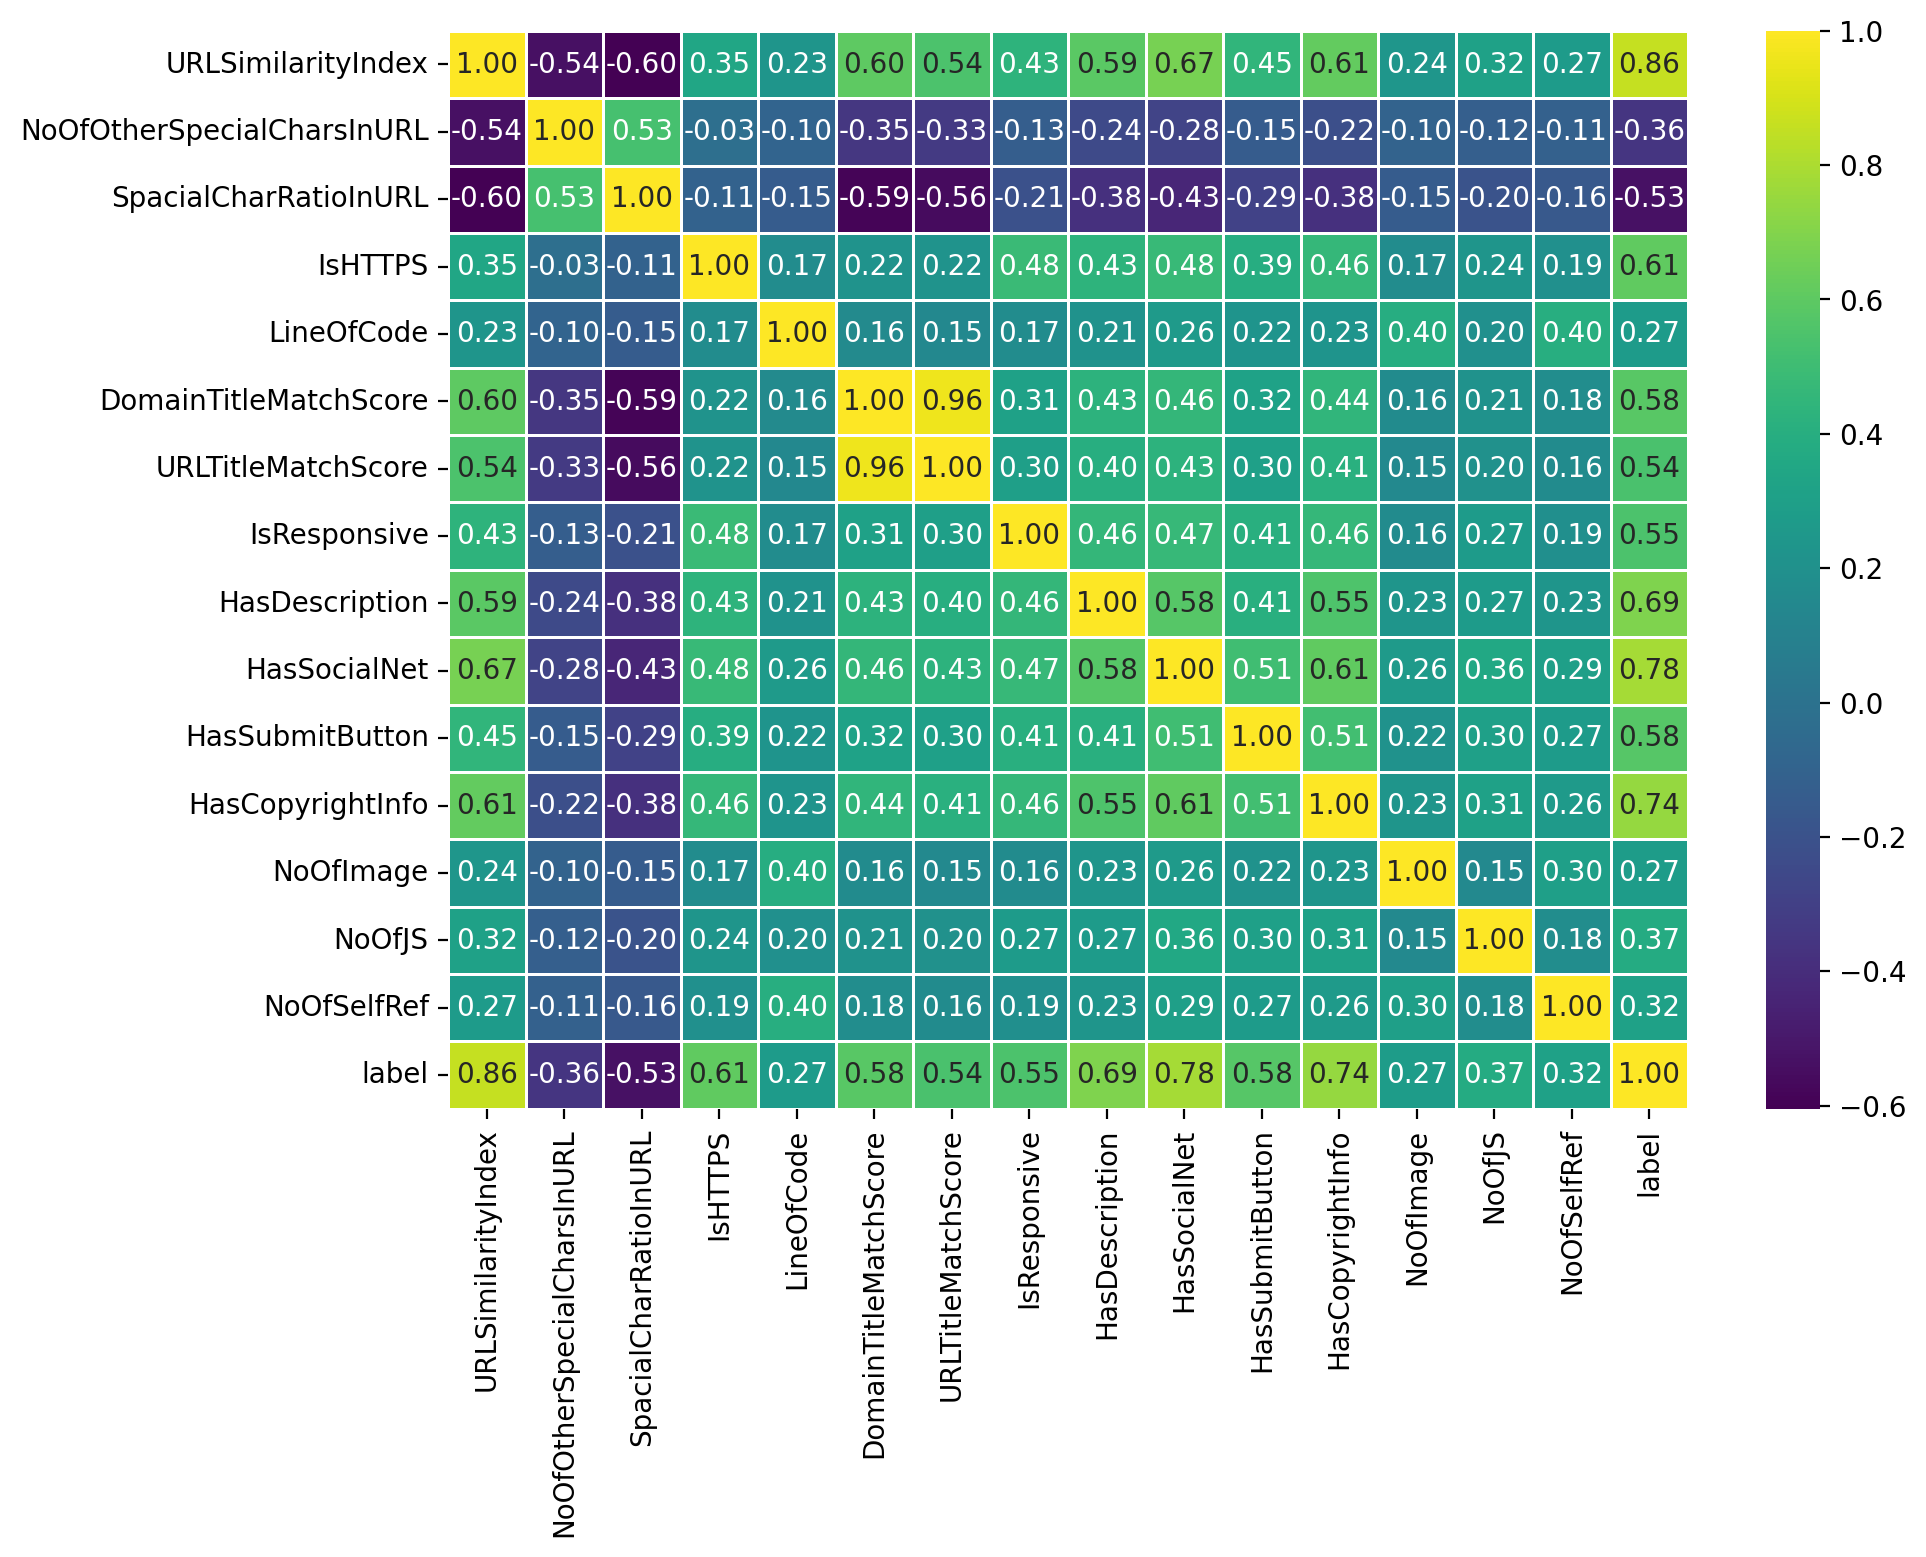

In [11]:
plt.figure(figsize=(10, 7), dpi=200)
sns.heatmap(data.corr(),
            cmap="viridis", linecolor="white",
            linewidths=0.5, annot=True, fmt=".2f")

In [12]:
cuttoff = int(len(df)*0.5)
df1 = df.iloc[:cuttoff]
df2 = df.iloc[cuttoff:]
df1.shape

(117897, 20)

In [13]:
df1.head()

,URL,Domain,TLD,URLSimilarityIndex,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,Title,DomainTitleMatchScore,URLTitleMatchScore,IsResponsive,HasDescription,HasSocialNet,HasSubmitButton,HasCopyrightInfo,NoOfImage,NoOfJS,NoOfSelfRef,label
0,https://www.southbankmosaics.com,www.southbankmosaics.com,com,100.0,1,0.032,1,558,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µ...,0.000000,0.000000,1,0,0,1,1,34,28,119,1
1,https://www.uni-mainz.de,www.uni-mainz.de,de,100.0,2,0.087,1,618,johannes gutenberg-universitÃ¤t mainz,55.555556,55.555556,0,0,1,1,1,50,8,39,1
2,https://www.voicefmradio.co.uk,www.voicefmradio.co.uk,uk,100.0,2,0.069,1,467,voice fm southampton,46.666667,46.666667,1,1,0,1,1,10,7,42,1
3,https://www.sfnmjournal.com,www.sfnmjournal.com,com,100.0,1,0.038,1,6356,home page: seminars in fetal and neonatal medi...,0.000000,0.000000,1,0,1,1,1,3,15,22,1
4,https://www.rewildingargentina.org,www.rewildingargentina.org,org,100.0,1,0.030,1,6089,fundaciÃ³n rewilding argentina,100.000000,100.000000,1,1,1,1,1,244,34,72,1


In [14]:
sub_df1 = df1.select_dtypes('object')
print(sub_df1.shape)
sub_df1['label'] = df1['label']
sub_df1['combined'] = sub_df1['URL'] + ' ' + sub_df1['Domain'] + ' ' + sub_df1['TLD'] + ' ' + sub_df1['Title']
sub_df1.head()

(117897, 4)


,URL,Domain,TLD,Title,label,combined
0,https://www.southbankmosaics.com,www.southbankmosaics.com,com,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µ...,1,https://www.southbankmosaics.com www.southbank...
1,https://www.uni-mainz.de,www.uni-mainz.de,de,johannes gutenberg-universitÃ¤t mainz,1,https://www.uni-mainz.de www.uni-mainz.de de j...
2,https://www.voicefmradio.co.uk,www.voicefmradio.co.uk,uk,voice fm southampton,1,https://www.voicefmradio.co.uk www.voicefmradi...
3,https://www.sfnmjournal.com,www.sfnmjournal.com,com,home page: seminars in fetal and neonatal medi...,1,https://www.sfnmjournal.com www.sfnmjournal.co...
4,https://www.rewildingargentina.org,www.rewildingargentina.org,org,fundaciÃ³n rewilding argentina,1,https://www.rewildingargentina.org www.rewildi...


In [15]:
train_texts = sub_df1.iloc[:61691]['combined'].values
train_labels = sub_df1.iloc[:61691]['label'].values

valid_texts = sub_df1.iloc[61691:79317]['combined'].values
valid_labels = sub_df1.iloc[61691:79317]['label'].values

test_texts = sub_df1.iloc[79317:]['combined'].values
test_labels = sub_df1.iloc[79317:]['label'].values

In [16]:
print(train_texts.shape)
print(valid_texts.shape)
print(test_texts.shape)

(61691,)
(17626,)
(38580,)


In [17]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [18]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

In [19]:
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [20]:
class URLDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = URLDataset(train_encodings, train_labels)
valid_dataset = URLDataset(valid_encodings, valid_labels)
test_dataset = URLDataset(test_encodings, test_labels)

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [22]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(DEVICE)
model.train()

optim = AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch"            # Save model at the end of each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset           # evaluation dataset
)

# Train the model
train_output = trainer.train()

# Get metrics from training logs
train_logs = trainer.state.log_history

# Extract train and validation loss and accuracy
train_loss = [log['loss'] for log in train_logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]
train_accuracy = [log['accuracy'] for log in train_logs if 'accuracy' in log]
eval_accuracy = [log['eval_accuracy'] for log in train_logs if 'eval_accuracy' in log]
epochs = range(1, len(train_loss) + 1)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


UsageError: api_key not configured (no-tty). call wandb.login(key=[your_api_key])

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for batch_idx, batch in enumerate(data_loader):

            ### Prepare data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs['loss'], outputs['logits']

            _, predicted_labels = torch.max(logits, 1)

            num_examples += labels.size(0)

            correct_pred += (predicted_labels == labels).sum()
    return correct_pred.float()/num_examples * 100

In [ ]:
model.eval()
model.to(DEVICE)

print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')

In [ ]:
# Save the fine-tuned model
model_output_dir = "./fine_tuned_model"

# Save the model
trainer.save_model(model_output_dir)

# Save the tokenizer (if using one)
tokenizer.save_pretrained(model_output_dir)

print(f"Model and tokenizer saved to {model_output_dir}")
